In [11]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.signal as signal
import warnings
from tqdm import tqdm
from matplotlib import cm

% matplotlib inline

# Helper function to calculate greater common divisor

In [12]:
def gcd(x, y):
    gcd = 1
    
    if x % y == 0:
        return y
    
    for k in range(int(y / 2), 0, -1):
        if x % k == 0 and y % k == 0:
            gcd = k
            break  
    return gcd

# Physical constants

In [13]:
eV = 1.6e-19

# Carbon structure constants

In [14]:
n, m = 4,2
print("chirality: ({},{})".format(n,m))

a_cc = 1.42e-10
print("carbon-carbon distance: {}".format(a_cc))

a_l = np.sqrt(3)*a_cc
print("lattice constant: {}".format(a_l))

# tight-binding parameters
e2p = 0
t0 = 2.7*eV
s0 = 0

# Coulomb interaction parameters
Upp = 11.3*eV
eps_0 = 8.85e-12 #[Farad/meter] vacuum permittivity
q_0 = 1.6e-19 #[Coulomb] electron charge
kappa = 2.0
Uhno_coeff = 4*np.pi*eps_0*Upp/(q_0**2)

# length of the CNT
number_of_unit_cells = 100

chirality: (4,2)
carbon-carbon distance: 1.42e-10
lattice constant: 2.4595121467478055e-10


# Graphene unit cells, chirality vector, translational vector


In [15]:
a1 = np.array([np.sqrt(3)/2, +1/2])*a_l
a2 = np.array([np.sqrt(3)/2, -1/2])*a_l
print("a1: {}".format(a1))
print("a2: {}".format(a2))

b1 = np.array([1/np.sqrt(3)*2*np.pi, 2*np.pi])/a_l
b2 = np.array([1/np.sqrt(3)*2*np.pi, -2*np.pi])/a_l
print("b1: {}".format(b1))
print("b2: {}".format(b2))

aCC_vec = 1./3.*(a1+a2)
print("aCC_vec: {}".format(aCC_vec))

ch_vec = n*a1+m*a2
print("ch_vec: {}".format(ch_vec))

ch_len = np.linalg.norm(ch_vec)
print("ch_len: {}".format(ch_len))

radius = ch_len/2/np.pi
print("radius: {}".format(radius))

dR = gcd(2*n+m, n+2*m)
t1 = int((2*m+n)/dR)
t2 = int(-(2*n+m)/dR)
t_vec = t1*a1+ t2*a2
print("t_vec: {}".format(t_vec))

Nu = int(2*(n**2+m**2+n*m)/dR)
print("Total number of hexagons in CNT unit cell: {}".format(Nu))
print()

cos_theta = ch_vec[0]/ch_len
sin_theta = ch_vec[1]/ch_len
rot_mat = np.array([[cos_theta, sin_theta], [-sin_theta, cos_theta]])

ch_vec = np.matmul(rot_mat, ch_vec)
t_vec = np.matmul(rot_mat, t_vec)
a1 = np.matmul(rot_mat, a1)
a2 = np.matmul(rot_mat, a2)
b1 = np.matmul(rot_mat, b1)
b2 = np.matmul(rot_mat, b2)
aCC_vec = np.matmul(rot_mat, aCC_vec)
print("ch_vec: {}".format(ch_vec))
print("t_vec: {}".format(t_vec))
print("a1: {}".format(a1))
print("a2: {}".format(a2))
print("b1: {}".format(b1))
print("b2: {}".format(b2))
print("aCC_vec: {}".format(aCC_vec))

a1: [  2.13000000e-10   1.22975607e-10]
a2: [  2.13000000e-10  -1.22975607e-10]
b1: [  1.47492613e+10   2.55464699e+10]
b2: [  1.47492613e+10  -2.55464699e+10]
aCC_vec: [  1.42000000e-10   0.00000000e+00]
ch_vec: [  1.27800000e-09   2.45951215e-10]
ch_len: 1.3014514973674584e-09
radius: 2.071324390003798e-10
t_vec: [ -2.13000000e-10   1.10678047e-09]
Total number of hexagons in CNT unit cell: 28

ch_vec: [  1.30145150e-09   0.00000000e+00]
t_vec: [  1.29246971e-25   1.12709006e-09]
a1: [  2.32402053e-10   8.05064328e-11]
a2: [  1.85921642e-10  -1.61012866e-10]
b1: [  1.93113161e+10   2.22987871e+10]
b2: [  9.65565804e+09  -2.78734838e+10]
aCC_vec: [  1.39441232e-10  -2.68354776e-11]


# Reciprocal lattice of CNT

In [16]:
K1 = (-t2*b1+t1*b2)/Nu
K2 = (+m*b1 -n*b2)/Nu
K2_normed = K2/np.linalg.norm(K2)
nk = number_of_unit_cells
dk_l = K2/nk

print("K1: {}".format(K1))
print("K2: {}".format(K2))
print("K2_normed: {}".format(K2_normed))
print("nk: {}".format(nk))
print("dk_l: {}".format(dk_l))

K1: [  4.82782902e+09   0.00000000e+00]
K2: [  2.72478376e-07   5.57469677e+09]
K2_normed: [  4.88777036e-17   1.00000000e+00]
nk: 100
dk_l: [  2.72478376e-09   5.57469677e+07]


# K2-extended representation

In [17]:
def get_K2_extended_params():
    print("t1:{}, t2:{}".format(t1, t2))
    p_min = (1/t1+1/n)/(m/n-t2/t1)
    p_max = (1/t1+Nu/n)/(m/n-t2/t1)
    
    q_min = t2/t1*p_max + 1/t1
    q_max = t2/t1*p_min + 1/t1
    for p in range(int(np.ceil(p_min)), int(np.ceil(p_max))):
        if (1+t2*p)%t1 == 0:
            q = int((1+t2*p)/t1)
            M = m*p - n*q
            Q = gcd(Nu, M)
            print("p:{} , q:{}, M:{}, Q:{}".format(p, q, M, Q))
            return p, q, M, Q
    
    print("Failed to detect (p,q)")

_,_, M, Q = get_K2_extended_params()
    

t1:4, t2:-5
p:1 , q:-1, M:6, Q:2


# Atom coordinates

/Users/amirhossein/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


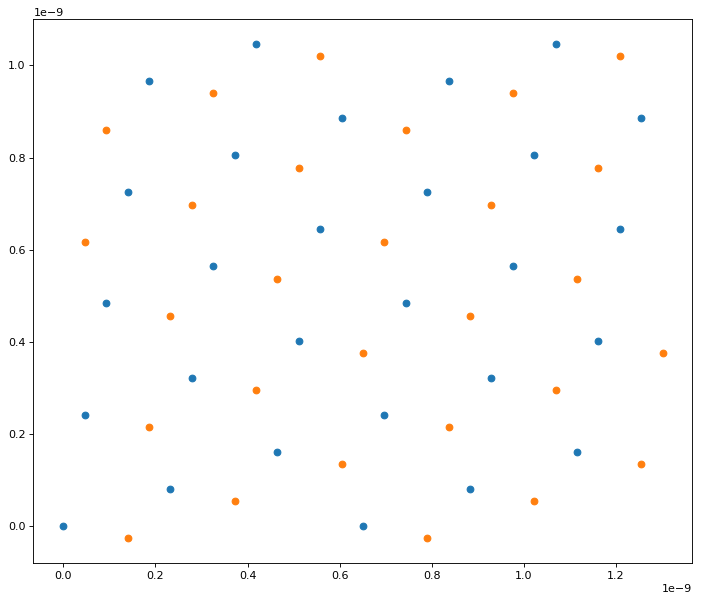

In [18]:
def get_atom_coordinates():
    pos_a = np.zeros((Nu,2))
    pos_b = np.zeros((Nu,2))
    
    count = 0
    for i in range(0, t1+n+1):
        for j in range(t2, m+1):
            
            flag1 = (float(t2*i)/float(t1) <= j)
            flag2 = (float(m*i)/float(n) >= j)
            flag3 = (float(t2*(i-n))/float(t1) > (j-m))
            flag4 = (float(m*(i-t1))/float(n) < (j-t2))
            
            if (flag1 and flag2 and flag3 and flag4):
                pos_a[count,:] = i*a1 + j*a2
                pos_b[count,:] = pos_a[count,:] + aCC_vec
                
                if(pos_a[count,0] > ch_vec[0]):
                    pos_a[count,0] -= ch_vec[0]
                if(pos_a[count,0] < 0.0):
                    pos_a[count,0] += ch_vec[0]
                if (pos_a[count,1] > ch_vec[1]):
                    pos_a[count,1] -= ch_vec[1]
                if(pos_a[count,1] < 0.0):
                    pos_a[count,1] += ch_vec[1]

                if(pos_b[count,0] > ch_vec[0]):
                    pos_b[count,0] -= ch_vec[0]
                if(pos_b[count,0] < 0.0):
                    pos_b[count,0] += ch_vec[0]
                if(pos_b[count,0] > ch_vec[1]):
                    pos_b[count,1] -= ch_vec[1]
                if(pos_b[count,1] < 0.0):
                    pos_b[count,1] += ch_vec[1]
                
                count += 1
    
    assert (count==Nu), "count: {}, Nu: {}".format(count, Nu)
    return pos_a, pos_b

pos_a, pos_b = get_atom_coordinates()

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(pos_a[:,0], pos_a[:,1], linestyle='none', marker='o', figure=fig)
plt.plot(pos_b[:,0], pos_b[:,1], linestyle='none', marker='o', figure=fig)
plt.axes().set_aspect('equal')

# relative distance between a-type and b-type atoms
pos_aa = pos_a-pos_a[0,:]
pos_ab = pos_a-pos_b[0,:]
pos_ba = pos_b-pos_a[0,:]
pos_bb = pos_b-pos_b[0,:]

pos_aa[pos_aa[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
pos_ba[pos_ba[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
pos_ab[pos_ab[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
pos_bb[pos_bb[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]

pos_2d = np.concatenate((pos_a, pos_b), axis=0)
pos_3d = np.stack((radius*np.cos(pos_2d[:,0]/radius), pos_2d[:,1], radius*np.sin(pos_2d[:,0])), axis=1)

# Function to get electron energy within a range of $k$ and $mu$

In [19]:
def electron_energy(n_k_min, n_k_max, n_mu_min, n_mu_max):
    n_k = n_k_max - n_k_min
    n_mu = n_mu_max - n_mu_min
    n_bands = 2
    n_atoms_in_unit_graphene_cell = n_bands
    energy = np.zeros((n_bands, n_k, n_mu))
    wavefunc = np.zeros((n_bands, n_k, n_mu, n_atoms_in_unit_graphene_cell),dtype='complex64')
    k_vector = np.zeros((n_k,1))
    for i_mu in range(n_mu_min,n_mu_max):
        for i_k in range(n_k_min, n_k_max):
            k_vector[i_k] = i_k*np.linalg.norm(dk_l)
            
            k_vec = i_mu*K1 + i_k*dk_l
            fk = np.exp(1j*np.dot(k_vec, (a1+a2)/3.))+np.exp(1j*np.dot(k_vec, (a1-2*a2)/3.))+ \
                                                            np.exp(1j*np.dot(k_vec, (a2-2*a1)/3.0))
            
            energy[0,i_k,i_mu] = np.real(-t0*np.abs(fk)) #valence band
            energy[1,i_k,i_mu] = np.real(+t0*np.abs(fk)) #conduction band
            
            wavefunc[0,i_k,i_mu,0] = 1./np.sqrt(2.)
            wavefunc[1,i_k,i_mu,0] = 1./np.sqrt(2.)
            wavefunc[0,i_k,i_mu,1] = +1./np.sqrt(2.)*np.conj(fk)/np.abs(fk)
            wavefunc[1,i_k,i_mu,1] = -1./np.sqrt(2.)*np.conj(fk)/np.abs(fk)
    return energy, wavefunc, k_vector

# Electron energy within $K_1$-extended representations

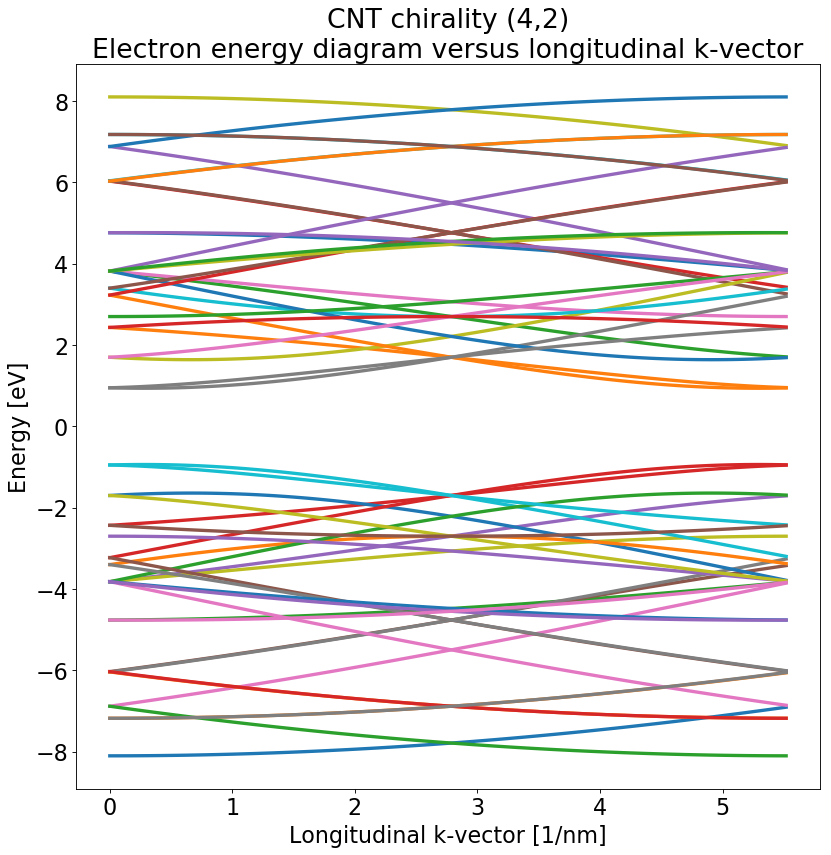

In [20]:
el_energy, el_wavefunc, k_vector = electron_energy(n_k_min=0, n_k_max=nk, n_mu_min=0, n_mu_max=Nu)

fig=plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(el_energy.shape[0]):
    for dim3 in range(el_energy.shape[2]):
        plt.plot(k_vector*1e-9, el_energy[dim1,:,dim3]/eV, linestyle='-', linewidth=3)
        
plt.title('CNT chirality ({},{})\nElectron energy diagram versus longitudinal k-vector'.format(n,m), size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
plt.savefig('K2_extended_electron_bandstructure')

# Electron bands within $K_2$-extended representations

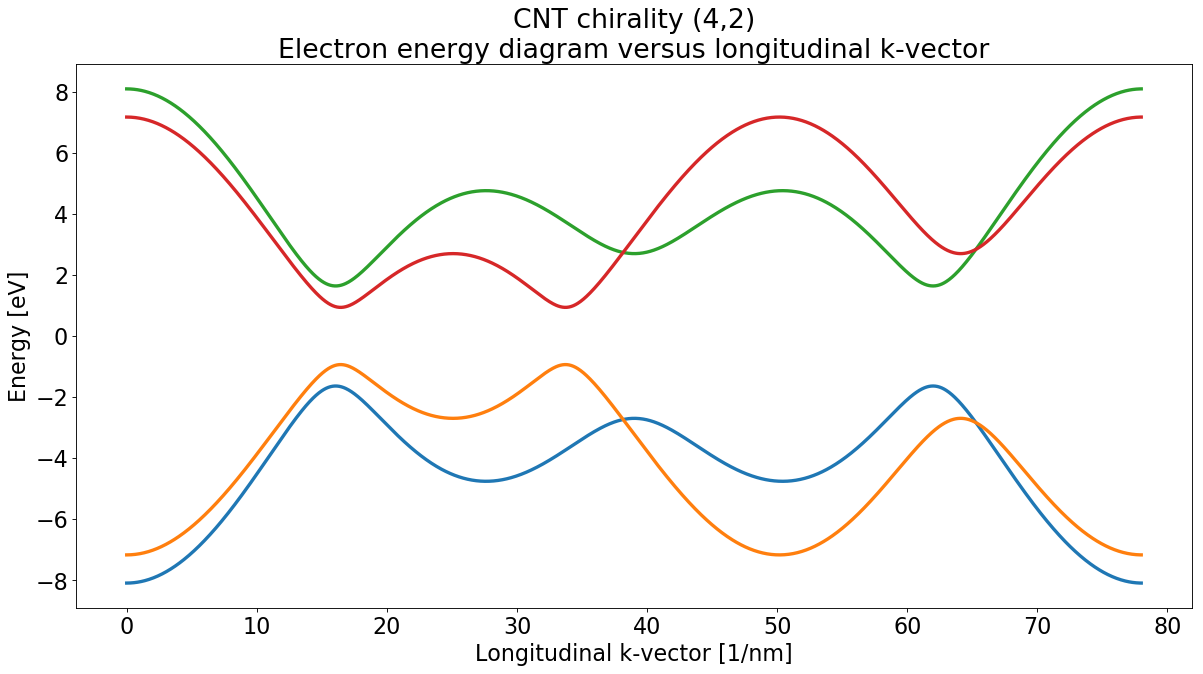

In [21]:
el_energy_K2ext, el_wavefunc_K2ext, k_vector_K2ext = \
        electron_energy(n_k_min=0, n_k_max=int(Nu/Q)*nk, n_mu_min=0, n_mu_max=Q)
# el_energy_K2ext, el_wavefunc_K2ext, k_vector_K2ext = \
#         electron_energy(n_k_min=-int(Nu/Q/2)*nk, n_k_max=int(Nu/Q/2)*nk, n_mu_min=0, n_mu_max=Q)

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(el_energy_K2ext.shape[0]):
    for dim3 in range(el_energy_K2ext.shape[2]):
        plt.plot(k_vector_K2ext*1e-9, el_energy_K2ext[dim1,:,dim3]/eV, linestyle='-', linewidth=3)
#         plt.plot(np.arange(0,el_energy_K2ext.shape[1]), el_energy_K2ext[dim1,:,dim3]/eV, linestyle='-', linewidth=3)
        
plt.title('CNT chirality ({},{})\nElectron energy diagram versus longitudinal k-vector'.format(n,m), size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
# plt.ylim([0.3e-18, 0.7e-18])
plt.savefig('K2_extended_electron_bandstructure.png')

# Find and sort minimas in $K_2$-extended representation and 

In [22]:
def get_local_min_indices(two_d_array):
    assert (len(two_d_array.shape) is 2), "Input array must be two dimensional"
    local_min_index = []
    for dim1 in range(two_d_array.shape[1]):
        local_min_index.append(signal.argrelextrema(two_d_array[:,dim1], np.less, mode='wrap')[0])
    local_min_index = np.array(local_min_index)
    assert (len(local_min_index.shape) is 2), "Could not find the index of local minimas" + \
            "properly. \n local_min_index.shape: {}".format(local_min_index.shape)
    return local_min_index

# this function gets the two-dimensional local minimum indexes and turns it into list of [idx, mu]
def flatten_local_min_indices(local_min_index):
    flattened = []
    for i_mu in range(local_min_index.shape[0]):
        for idx in local_min_index[i_mu,:]:
            flattened.append([idx,i_mu])
    return flattened

# this function sort indices in order of their value in energy matrix
def bubble_sort(indices, energy):
    changed = True
    while changed:
        changed = False
        for i in range(len(indices) - 1):
            ik = indices[i][0]
            mu = indices[i][1]
            ik_plus_1 = indices[i+1][0]
            mu_plus_1 = indices[i+1][1]
            if energy[1,ik, mu] > energy[1,ik_plus_1, mu_plus_1]:
                indices[i], indices[i+1] = indices[i+1], indices[i]
                changed = True
    return indices

def find_equivalent_minimas(local_min_index, energy):
#     assert (len(local_min_index)%2 is 0), "Number of local minimas is not even: {}".format(len(local_min_index))
    if (len(local_min_index)%2 != 0):
        warnings.warn("Number of local minimas is not even: {}".format(len(local_min_index)))
    equivalent_minimas = []
    for i in range(int(len(local_min_index)/2)):
        equivalent_minimas.append([local_min_index[2*i], local_min_index[2*i+1]])
    
    # check if the equivalent valeies are really equivalent
    for item in equivalent_minimas:
        en1 = energy[1,item[0][0], item[0][1]]
        en2 = energy[1,item[1][0], item[1][1]]
        assert (np.abs(en1-en2)/np.mean([en1, en2]) < 1.e-2), "Error in finding equivalent valeys"
    return equivalent_minimas
        
local_min_index = get_local_min_indices(el_energy_K2ext[1,:,:])
print(local_min_index)
local_min_index = flatten_local_min_indices(local_min_index)
local_min_index = bubble_sort(local_min_index, el_energy_K2ext)
local_min_index = find_equivalent_minimas(local_min_index, el_energy_K2ext)
print(local_min_index)

[[ 288  700 1112]
 [ 295  605 1150]]
[[[295, 1], [605, 1]], [[288, 0], [1112, 0]], [[700, 0], [1150, 1]]]


# Find $k_c$ values in range that are energetically relevant

(2, 175, 2)
226
500


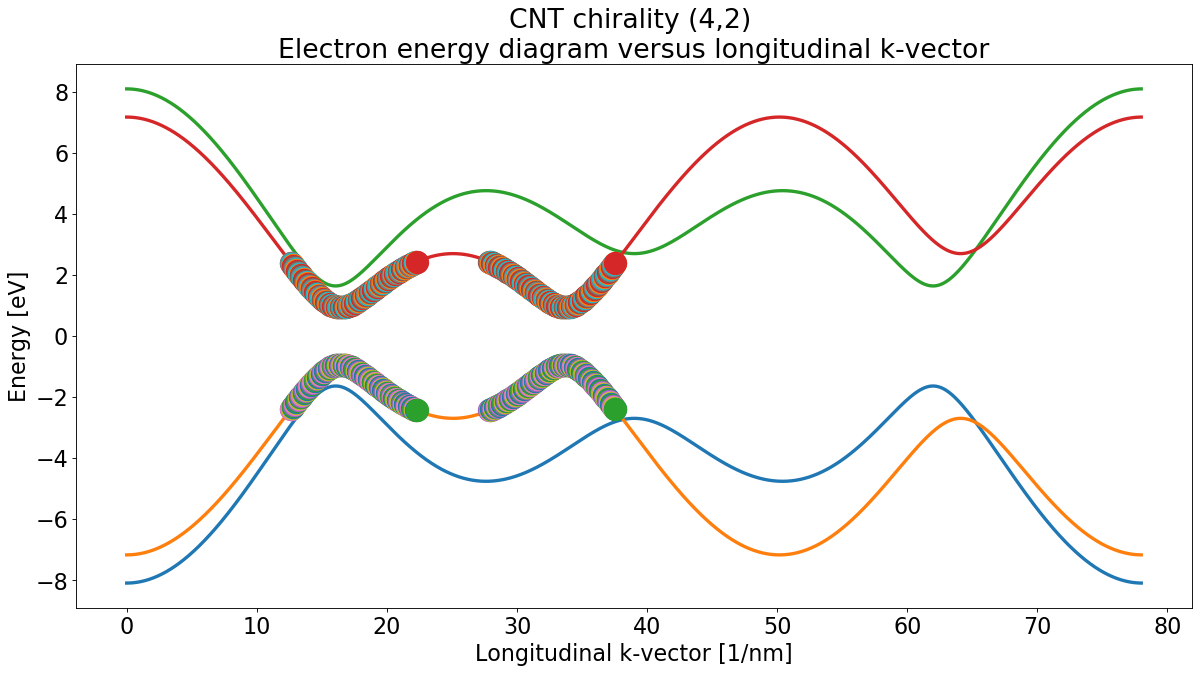

In [23]:
def find_kc_range(i_sub, min_indices, delta_energy, energy):
    ikc_range = [[],[]]
    
    # scan the first valey
    i_valey = 0
    ik_min = min_indices[i_sub][i_valey][0]
    mu_min = min_indices[i_sub][i_valey][1]
    max_energy = energy[1,ik_min, mu_min] + delta_energy
    
    ikc_range[0].append([ik_min, mu_min])
    in_range = True
    count = 0
    while(in_range):
        in_range = False
        count = count+1
        ik = ik_min + count
        while (ik >= energy.shape[1]):
            ik -= energy.shape[1]
        if (energy[1,ik,mu_min] < max_energy):
            ikc_range[i_valey].append([ik,mu_min])
            in_range = True

        ik = ik_min - count
        while (ik < 0):
            ik += energy.shape[1]
        if (energy[1,ik,mu_min] < max_energy):
            ikc_range[i_valey].insert(0,[ik,mu_min])
            in_range = True
    
    # scan the second valey
    i_valey = 1
    ik_min = min_indices[i_sub][i_valey][0]
    mu_min = min_indices[i_sub][i_valey][1]
    
    ikc_range[i_valey].append([ik_min, mu_min])
    in_range = True
    count = 0
    while(in_range):
        in_range = False
        count = count+1
        ik = ik_min + count
        while (ik >= energy.shape[1]):
            ik -= energy.shape[1]
        if (energy[1,ik,mu_min] < max_energy):
            ikc_range[i_valey].append([ik,mu_min])
            in_range = True

        ik = ik_min - count
        while (ik < 0):
            ik += energy.shape[1]
        if (energy[1,ik,mu_min] < max_energy):
            ikc_range[i_valey].insert(0,[ik,mu_min])
            in_range = True
            
    assert len(ikc_range[0]) == len(ikc_range[1]), \
        "Number of states in equivalent valleys are different: len(ikc_range[0])={}, len(ikc_range[1])={}"\
        .format(len(ikc_range[0]), len(ikc_range[1]))
    
    return ikc_range

ikc_range = find_kc_range(i_sub=0, min_indices=local_min_index, delta_energy=1.5*eV, energy=el_energy_K2ext)
ikc_range = np.array(ikc_range, dtype='int')
# ikc_range = np.sort(ikc_range, axis=1)
print(ikc_range.shape)

def plot_kc_range(ikc_range, energy, k_vec):
    
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for dim1 in range(energy.shape[0]):
        for dim3 in range(energy.shape[2]):
            plt.plot(k_vec*1e-9, energy[dim1,:,dim3]/eV, linestyle='-', linewidth=3)

    selected_energy = []
    for i_valley in range(ikc_range.shape[0]):
        for j in range(ikc_range.shape[1]):
            for i_band in range(2):
                ik = ikc_range[i_valley,j,0]
                mu = ikc_range[i_valley,j,1]
                plt.plot(k_vec[ik]*1e-9, energy[i_band,ik,mu]/eV, marker='o', markersize=20)
    
    plt.title('CNT chirality ({},{}) \nElectron energy diagram versus longitudinal k-vector'.format(n,m), size=24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
    plt.ylabel('Energy [eV]', size=20)
    plt.savefig('K2_extended_electron_bandstructure_highliting_valleys.png')

plot_kc_range(ikc_range=ikc_range, energy=el_energy_K2ext, k_vec=k_vector_K2ext)
print(ikc_range[0,0,0])
print(ikc_range[1,0,0])

# Function to get index of valence band state
This function includes wrapping around the $K_2$-extended zone and deals with cases were exciton $k_v$ lies outside of the relevant electronic states.

In [24]:
def get_ikv(ik_c, ik_cm, ikv_limits, ik_limits, mode='extend'):
    """
    get index of valence band state by taking care of wrapping around
        the K2-extended zone
    the limits in this function is defined as [a,b) so that the upper limit
        of values are b-1 and the lower limit is a.
    ikv_limits: list like [a,b) where a is the lower limit of ikv and ikc
                and b is the upper limit of ikv and ikc, so ikv can be at most b-1
    ik_limits=[a,b) is the limit of K1-extended zone
    """
    
    ik_v = ik_c-ik_cm
    
    # to wrap the index around when it goes beyond the boundary
    while (ik_v > ik_limits[-1]):
        ik_v -= len(ik_limits)
    while (ik_v < ik_limits[0]):
        ik_v += len(ik_limits)
    if mode == 'extend':
        return ik_v
    elif mode == 'clip':
        # to deal with normal cases that valley is not close to the edges
        if (ikv_limits[0]<ikv_limits[-1]): 
            if ik_v<ikv_limits[0]:
                ik_v = ikv_limits[0]
            elif ik_v>ikv_limits[-1]:
                ik_v = ikv_limits[-1]
        # to deal with cases that the valley is close to edges
        else:
            if (ik_v<ikv_limits[0]) and (ik_v>ikv_limits[-1]):
                ik_v = ikv_limits[0] if (abs(ik_v-ikv_limits[0]) < abs(ik_v-ikv_limits[-1])) else ikv_limits[-1]
        return ik_v
    elif mode == 'eliminate':
        # to deal with normal cases that valley is not close to the edges
        if (ikv_limits[0]<ikv_limits[-1]): 
            if ik_v<ikv_limits[0]:
                return None
            elif ik_v>ikv_limits[-1]:
                return None
            return ik_v
        # to deal with cases that the valley is close to edges
        else:
            if (ik_v<ikv_limits[0]) and (ik_v>ikv_limits[-1]):
                return None
            return ik_v
    else:
        raise Exception('Unknown mode!')
        
def get_ikc(ik_v, ik_cm, ikc_limits, ik_limits, mode='extend'):
    """
    get index of conduction band state by taking care of wrapping around
        the K2-extended zone
    the limits in this function is defined as [a,b] so that the upper limit
        of values are b and the lower limit is a.
    ikc_limits: range-like range(a,b+1) where a is the lower limit of ikv and ikc
                and b is the upper limit of ikv and ikc, so ikv can be at most b
    ik_limits=range(a,b+1) is the limit of K1-extended zone
    """
    
    ik_c = ik_v+ik_cm
    
    # to wrap the index around when it goes beyond the boundary
    while (ik_c > ik_limits[-1]):
        ik_c -= len(ik_limits)
    while (ik_c < ik_limits[0]):
        ik_c += len(ik_limits)
    if mode == 'extend':
        return ik_c
    elif mode == 'clip':
        # to deal with normal cases that valley is not close to the edges
        if (ikc_limits[0]<ikc_limits[-1]): 
            if ik_c<ikc_limits[0]:
                ik_c = ikc_limits[0]
            elif ik_c>ikc_limits[-1]:
                ik_c = ikc_limits[-1]
        # to deal with cases that the valley is close to edges
        else:
            if (ik_c<ikc_limits[0]) and (ik_c>ikc_limits[-1]):
                ik_c = ikc_limits[0] if (abs(ik_c-ikc_limits[0]) < abs(ik_c-ikc_limits[-1])) else ikc_limits[-1]
        return ik_c
    elif mode == 'eliminate':
        # to deal with normal cases that valley is not close to the edges
        if (ikc_limits[0]<ikc_limits[-1]): 
            if ik_c<ikc_limits[0]:
                return None
            elif ik_c>ikc_limits[-1]:
                return None
            return ik_c
        # to deal with cases that the valley is close to edges
        else:
            if (ik_c<ikc_limits[0]) and (ik_c>ikc_limits[-1]):
                return None
            return ik_c
    else:
        raise Exception('Unknown mode!')


def test_get_ikv():
    ik_limits = range(0,200)
    ikv_limits = list(range(186,200))+list(range(0,15))
    ikv_test = get_ikv(ik_c=15, ik_cm=0, ikv_limits=ikv_limits, ik_limits=ik_limits, mode='clip')
    print("ikv_test: {}".format(ikv_test))
    
def test_get_ikc():
    ik_limits = range(0,200)
    ikc_limits = list(range(186,200))+list(range(0,15))
    ikc_test = get_ikc(ik_v=15, ik_cm=0, ikc_limits=ikc_limits, ik_limits=ik_limits, mode='clip')
    print("ikc_test: {}".format(ikc_test))

test_get_ikv()
test_get_ikc()

ikv_test: 14
ikc_test: 14


# Form exciton energy without interaction kernels

## Asymmetry of transition energy dispersion
As we can see in the output figures, if we use the `extend` mode, the dispersion of the transition energies is not going to be symmetric. And the direction of this asymmetry is dependent on choosing `ikc` or `ikv` as the independent variable.

Therefore, it is obvious that the asymmetry is not a physical phenomena and if we exclude the transitions where either `ikc` or `ikv` lie outside of `ikc_range` (`eliminate` mode), we end up with a symmetric transition energy dispersion.

Text(0,0.5,'Energy [eV]')

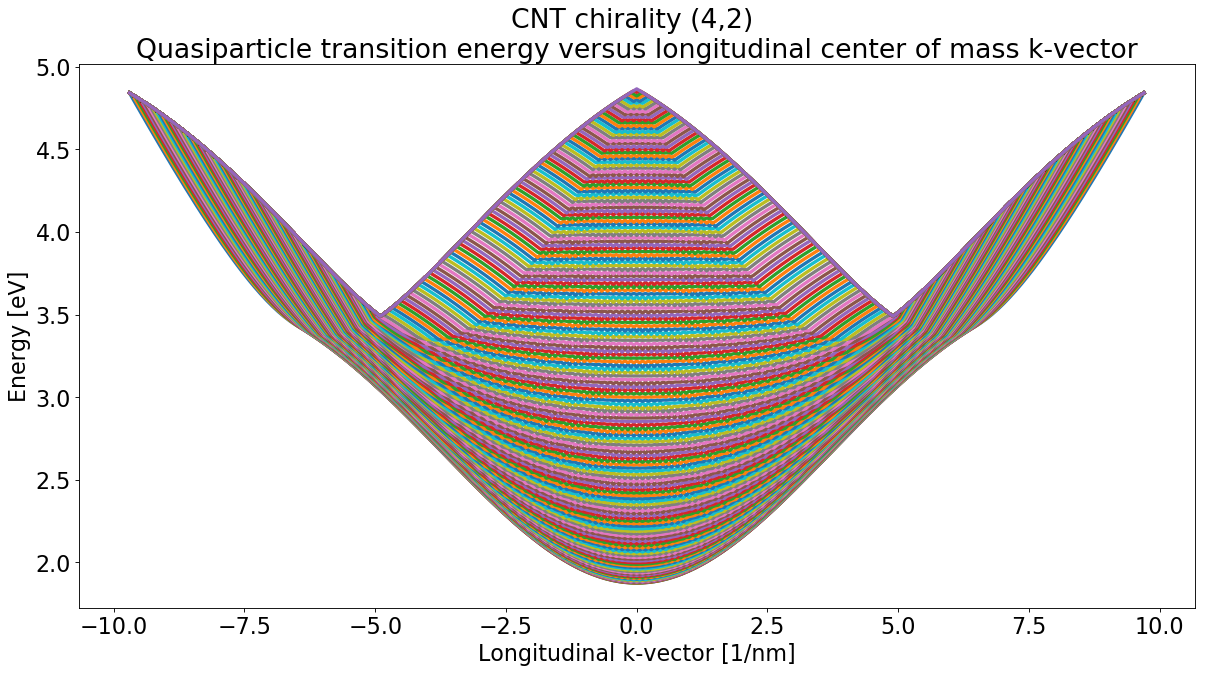

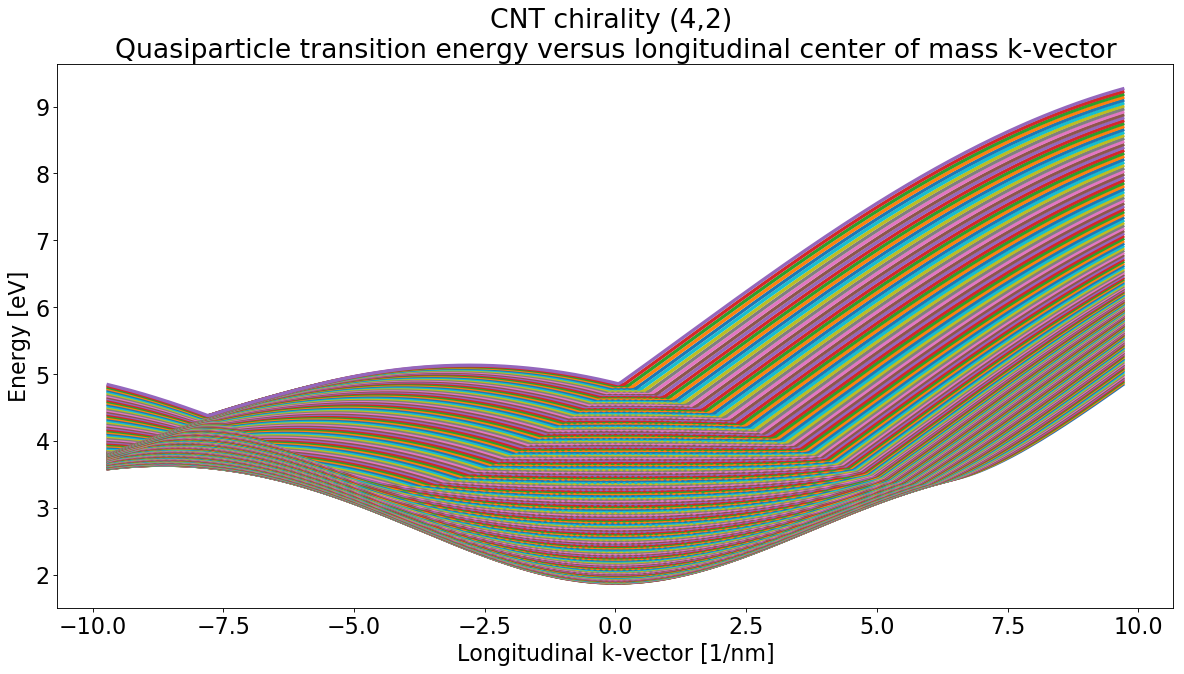

In [25]:
def get_transition_energies_based_on_ikc(i_valley, ikc_range, energy, mode):
    ik_cm_limits = range(-(ikc_range.shape[1]-1), (ikc_range.shape[1]-1)+1)
    nk_cm = len(ik_cm_limits)
    n_kc = ikc_range.shape[1]
    ex_energy = np.zeros((nk_cm,n_kc))
    k_cm_vec = np.zeros((nk_cm,1))
    
    ikc_limits = ikc_range[i_valley,:,0]
    ik_limits = range(0,energy.shape[1])

    for ik_cm in ik_cm_limits:
        E_quasi = np.zeros((n_kc))
        k_cm_vec[ik_cm-ik_cm_limits[0]] = ik_cm*np.linalg.norm(dk_l)
        for idx in range(n_kc):
            i_kc = ikc_range[i_valley,idx,0]
            mu = ikc_range[i_valley, idx, 1]
            
            i_kv = get_ikv(i_kc, ik_cm, ikc_limits, ik_limits, mode)
            if i_kv is None:
                E_quasi[idx] = -1
            else:
                E_quasi[idx] = energy[1,i_kc,mu] - energy[0,i_kv,mu]
                
        E_quasi[E_quasi < 0] = np.amax(E_quasi)

        E_quasi = np.sort(E_quasi,kind='heapsort')
        ex_energy[ik_cm-ik_cm_limits[0],:] = E_quasi
    return ex_energy, k_cm_vec

def get_transition_energies_based_on_ikv(i_valley, ikc_range, energy, mode):
    ik_cm_limits = range(-(ikc_range.shape[1]-1), (ikc_range.shape[1]-1)+1)
    nk_cm = len(ik_cm_limits)
    n_kc = ikc_range.shape[1]
    ex_energy = np.zeros((nk_cm,n_kc))
    k_cm_vec = np.zeros((nk_cm,1))
    
    ikc_limits = ikc_range[i_valley,:,0]
    ik_limits = range(0,energy.shape[1])

    for ik_cm in ik_cm_limits:
        E_quasi = np.zeros((n_kc))
        k_cm_vec[ik_cm-ik_cm_limits[0]] = ik_cm*np.linalg.norm(dk_l)
        for idx in range(n_kc):
            i_kv = ikc_range[i_valley,idx,0]
            mu = ikc_range[i_valley, idx, 1]
            
            i_kc = get_ikc(i_kv, ik_cm, ikc_limits, ik_limits, mode)
            if i_kv is None:
                E_quasi[idx] = -1
            else:
                E_quasi[idx] = energy[1,i_kc,mu] - energy[0,i_kv,mu]
                
        E_quasi[E_quasi < 0] = np.amax(E_quasi)

        E_quasi = np.sort(E_quasi,kind='heapsort')
        ex_energy[ik_cm-ik_cm_limits[0],:] = E_quasi
    return ex_energy, k_cm_vec

quasi_particle_energy, k_cm_vec = get_transition_energies_based_on_ikc(i_valley=0, ikc_range=ikc_range, \
                                              energy=el_energy_K2ext, mode='eliminate')
    
fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(quasi_particle_energy.shape[1]):
    plt.plot(k_cm_vec*1e-9, quasi_particle_energy[:,dim1]/eV, linestyle='-', linewidth=3)
plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
          'Quasiparticle transition energy versus longitudinal center of mass k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
# plt.savefig('Quasiparticle_transition_energy_using_K2extended_rep.png')

quasi_particle_energy, k_cm_vec = get_transition_energies_based_on_ikv(i_valley=1, ikc_range=ikc_range, \
                                              energy=el_energy_K2ext, mode='extend')
    
fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(quasi_particle_energy.shape[1]):
    plt.plot(k_cm_vec*1e-9, quasi_particle_energy[:,dim1]/eV, linestyle='-', linewidth=3)
plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
          'Quasiparticle transition energy versus longitudinal center of mass k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
# plt.savefig('Quasiparticle_transition_energy_using_K2extended_rep.png')

# Calculate $v_{b,b'}(q)$

Note that $v_{b,b'}(q)$ is periodic with the length of the $K_2$-extended representation of the CNT, as opposed to the length of the $K_1$-extended representation of the CNT. This is because the periodicity would rise from the atomic structure of the underlying graphene sheet as well as the CNT unit cell itself.

100%|██████████| 2799/2799 [00:05<00:00, 522.30it/s]


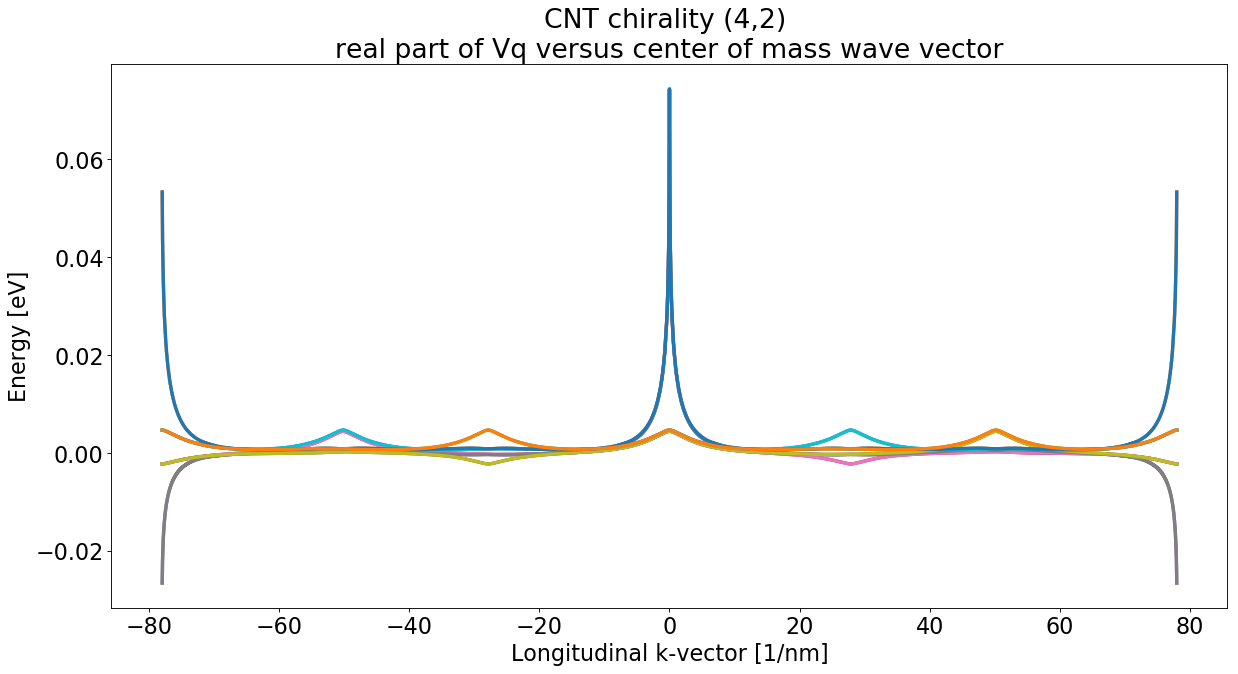

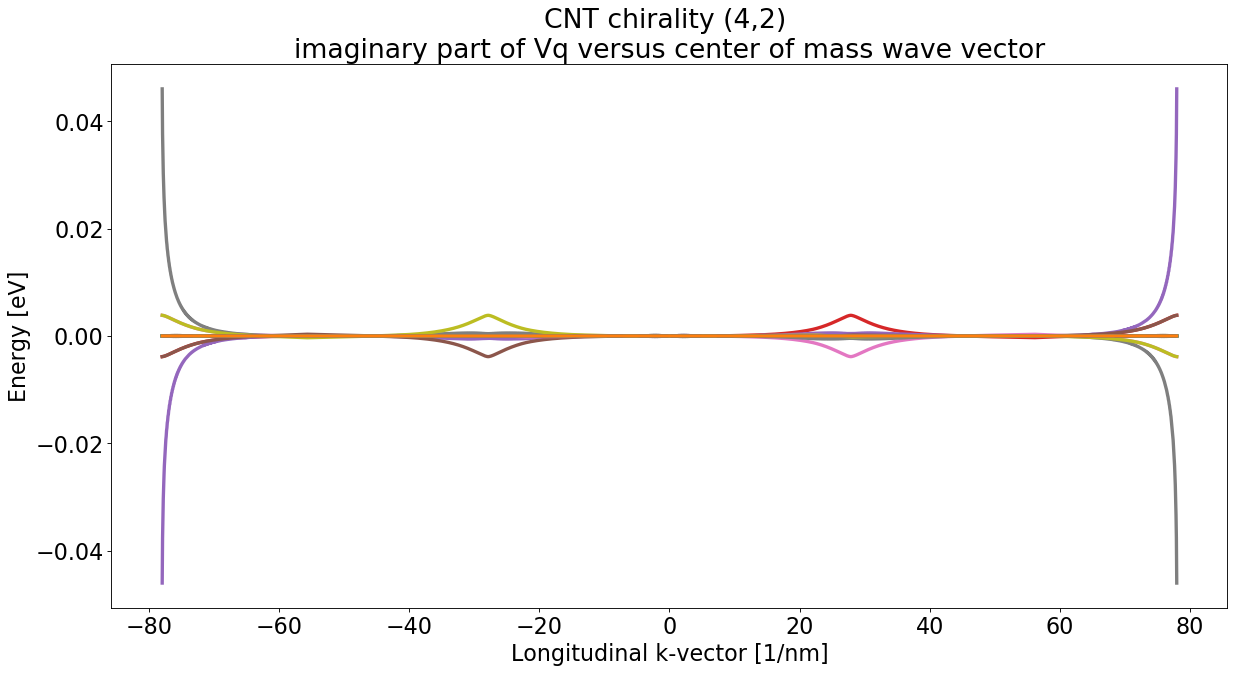

In [26]:
def Uhno(deltaR):
    """
    Returns the Uhno potential for an array of atoms
    
    deltaR: vector of atom positions in the shape (N_atoms,2) where the first dimension
              is span over the atoms and the second dimension is the x and y coordinate of
              the corresponding atom.
    """
    return Upp/np.sqrt(np.square(Uhno_coeff*np.linalg.norm(deltaR,axis=1))+1)

def calculate_vq(iq_limits, mu_limits, no_of_cnt_unit_cells, pos_a=pos_a,\
                         pos_b=pos_b, t_vec=t_vec, ch_vec=ch_vec):
    
    assert (no_of_cnt_unit_cells%2 == 1), "Nu must be an odd number!"
    
    Nu = pos_a.shape[0]
    rel_pos = np.zeros((2,2,no_of_cnt_unit_cells*Nu,2))
    
    # relative distance between a-type and b-type atoms
    pos_aa = pos_a-pos_a[0,:]
    pos_ab = pos_a-pos_b[0,:]
    pos_ba = pos_b-pos_a[0,:]
    pos_bb = pos_b-pos_b[0,:]

    pos_aa[pos_aa[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
    pos_ba[pos_ba[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
    pos_ab[pos_ab[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
    pos_bb[pos_bb[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
    

    for i in range(-int(no_of_cnt_unit_cells/2),int(no_of_cnt_unit_cells/2)+1):
        idx = (i+int(no_of_cnt_unit_cells/2))*Nu
        rel_pos[0,0,idx:idx+Nu,:] = pos_aa+i*t_vec
        rel_pos[0,1,idx:idx+Nu,:] = pos_ab+i*t_vec
        rel_pos[1,0,idx:idx+Nu,:] = pos_ba+i*t_vec
        rel_pos[1,1,idx:idx+Nu,:] = pos_bb+i*t_vec
        
    vq = np.zeros((2,2,len(iq_limits),len(mu_limits)),dtype='complex64')
    
    q_vec = np.zeros((len(iq_limits),1))
    
    q = np.zeros((2,1))
    for iq in tqdm(iq_limits):
        iq_idx = iq - iq_limits[0]
        q_vec[iq_idx] = iq*np.linalg.norm(dk_l)
        for mu_idx, mu in enumerate(mu_limits):
            q = iq*dk_l + mu*K1
            for i in range(2):
                for j in range(2):
                    vq[i,j,iq_idx,mu_idx] = \
                            np.dot(np.exp(1j*np.matmul(rel_pos[i,j,:,:],q)),Uhno(rel_pos[i,j,:,:]))
    vq = vq/(2*Nu*no_of_cnt_unit_cells)
    
    return vq,q_vec

def plot_vq():
#     ikcm_lim = range(-(ikc_range.shape[1]-1),+(ikc_range.shape[1]-1)+1)
    ikcm_lim = range(-(el_energy_K2ext.shape[1]-1),el_energy_K2ext.shape[1])
    mu_limits = range(-Q+1,Q)
#     mu_limits = range(0,2)
    vq,q_vec = calculate_vq(ikcm_lim, mu_limits,number_of_unit_cells+1)
    vq = vq/eV
    
    # plot real part
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for i in range(2):
        for j in range(2):
            plt.plot(q_vec*1e-9, (np.real(vq[i,j,:,:])), linestyle='-', linewidth=3)
            
    plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
              'real part of Vq versus center of mass wave vector', size=24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
    plt.ylabel('Energy [eV]', size=20)
    plt.savefig('vq_using_K2extended_rep.png')
    
    
    # plot imaginary part
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for i in range(2):
        for j in range(2):
            plt.plot(q_vec*1e-9, (np.imag(vq[i,j,:,:])), linestyle='-', linewidth=3)
    
    plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
              'imaginary part of Vq versus center of mass wave vector', size=24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
    plt.ylabel('Energy [eV]', size=20)
    plt.savefig('vq_using_K2extended_rep.png')
    
plot_vq()

# Calculate polarization

100%|██████████| 2799/2799 [09:32<00:00,  4.89it/s]


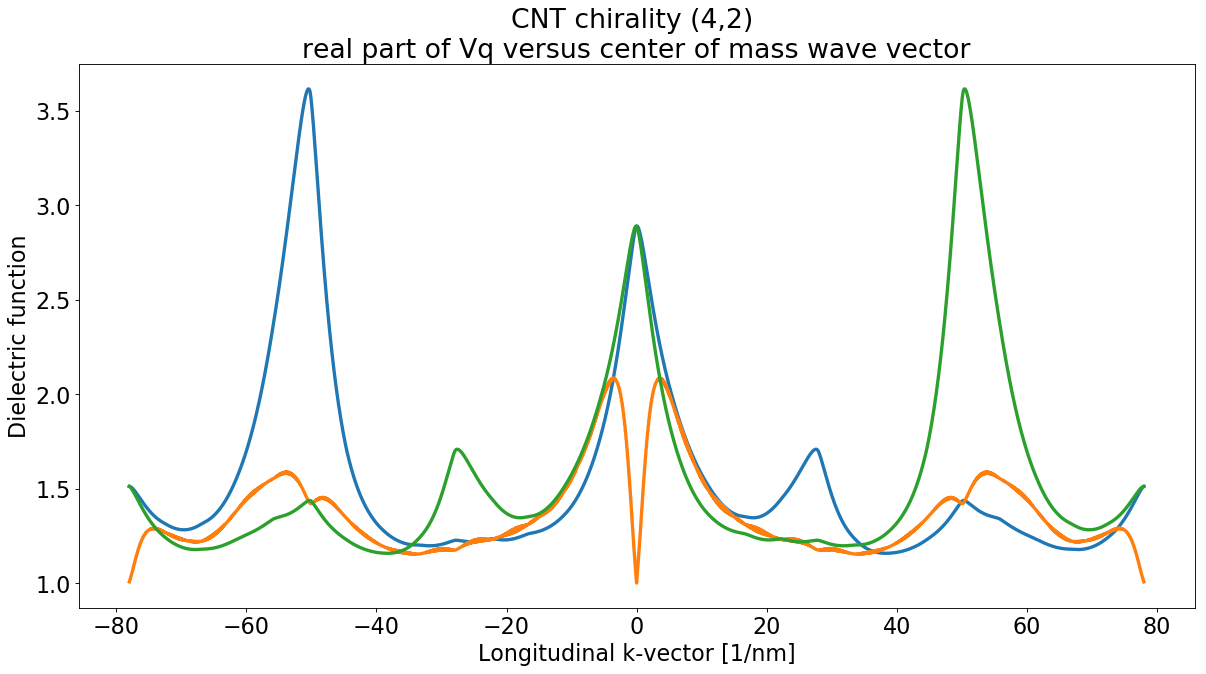

In [27]:

def calculate_PI(iq_limits, mu_q_limits, energy, wavefunc):
    
    def get_kq(ik,iq,mu_k,mu_q,ik_limits,mu_k_limits):
        mu_kq = mu_k+mu_q
        ikq = ik+iq
        while mu_kq >= mu_k_limits[-1]:
            mu_kq -= len(mu_k_limits)
            ikq += nk*M
        while mu_kq < mu_k_limits[0]:
            mu_kq += len(mu_k_limits)
            ikq -= nk*M
        
        while ikq >= ik_limits[-1]:
            ikq -= len(ik_limits)
        while ikq < ik_limits[0]:
            ikq += len(ik_limits)
        return ikq,mu_kq
        
    ik_limits = range(0,energy.shape[1])
    mu_k_limits = range(0,energy.shape[2])
    
    PI = np.zeros((len(iq_limits),len(mu_q_limits))) 
    q_vec = np.zeros((len(iq_limits),1))
    
    q = np.zeros((2,1))
    for iq_idx, iq in enumerate(tqdm(iq_limits)):
        q_vec[iq_idx] = iq*np.linalg.norm(dk_l)
        for mu_q_idx, mu_q in enumerate(mu_q_limits):
            for ik in ik_limits:
                ik_idx = ik-ik_limits[0]
                for mu_k in mu_k_limits:
                    ikq, mu_kq = get_kq(ik, iq, mu_k, mu_q, ik_limits, mu_k_limits)
                    PI[iq_idx,mu_q_idx] += np.square(np.abs(np.dot(np.conj(wavefunc[0,ik,mu_k,:]),wavefunc[1,ikq,mu_kq,:])))/ \
                                        (energy[1,ikq,mu_kq]-energy[0,ik,mu_k]) + \
                                       np.square(np.abs(np.dot(np.conj(wavefunc[1,ik,mu_k,:]),wavefunc[0,ikq,mu_kq,:])))/ \
                                        (energy[1,ik,mu_k]-energy[0,ikq,mu_kq])
    PI = 2*PI
                    
                    
    
    return PI,q_vec

def plot_eps():
#     ikcm_lim = range(-(ikc_range.shape[1]-1),+(ikc_range.shape[1]-1)+1)
    ikcm_lim = range(-(el_energy_K2ext.shape[1]-1),el_energy_K2ext.shape[1])
    mu_lim = range(-(Q-1),Q)
    vq,q_vec = calculate_vq(ikcm_lim, mu_lim,number_of_unit_cells+1)
    vq_mean = np.real(np.mean(vq,axis=(0,1)))
    PI,q_vec = calculate_PI(ikcm_lim, mu_lim,el_energy_K2ext,el_wavefunc_K2ext)    
    eps = 1+np.multiply(vq_mean,PI)
    
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(q_vec*1e-9, eps[:,:], linestyle='-', linewidth=3)
            
    
    
    plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
              'real part of Vq versus center of mass wave vector', size=24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
    plt.ylabel('Dielectric function', size=20)
    plt.savefig('dielectric_function_using_K2extended_rep.png')
    
    return eps, vq, q_vec
    
eps, vq, q_vec = plot_eps()

# Create the direct Kernel plus the transition energy

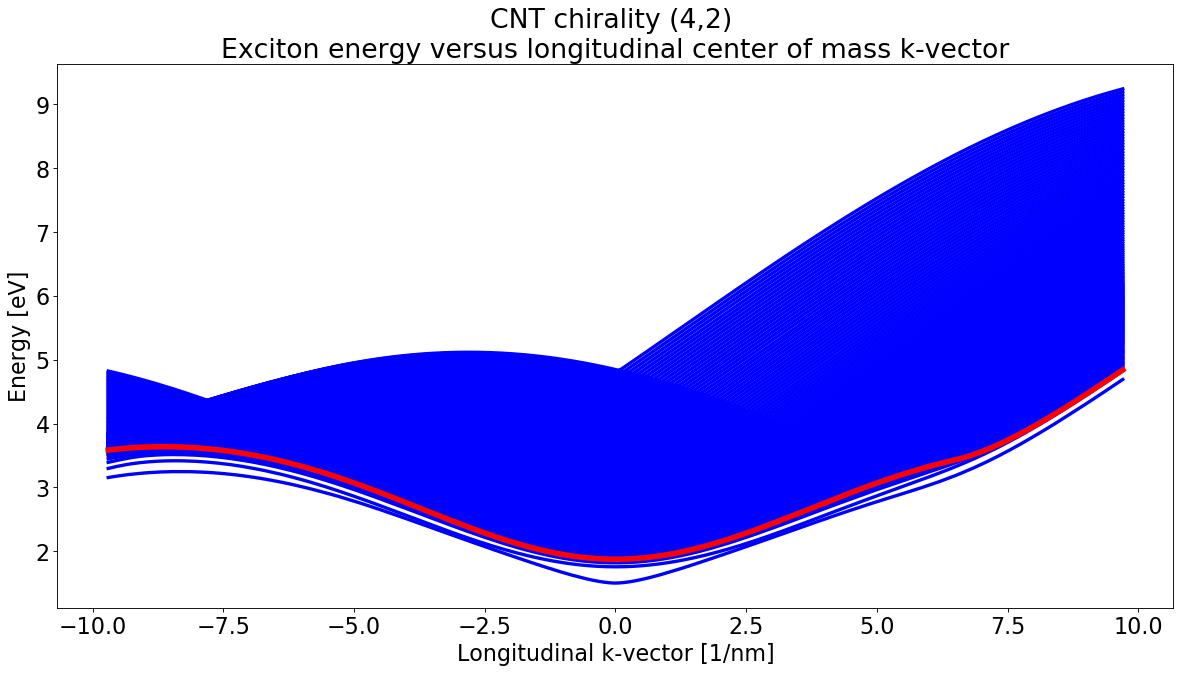

In [29]:
def get_direct_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,mu_cp,ik_vp,mu_vp,wavefunc,\
                           vq,eps,iq_limits,mu_limits,ik_limits):
    ikc_diff = ik_c-ik_cp
    while(ikc_diff < ik_limits[0]):
        ikc_diff += len(ik_limits)
    while(ikc_diff > ik_limits[-1]):
        ikc_diff -= len(ik_limits)

    dir_interaction = 0
    for i in range(2):
        for j in range(2):                    
            dir_interaction += np.conj(wavefunc[1,ik_c,mu_c,i])*wavefunc[0,ik_v,mu_v,j]* \
                               wavefunc[1,ik_cp,mu_cp,i]*np.conj(wavefunc[0,ik_vp,mu_vp,j])* \
                               vq[i,j,ikc_diff-iq_limits[0],mu_c-mu_cp-mu_limits[0]]/ \
                               eps[ikc_diff-iq_limits[0],mu_c-mu_cp-mu_limits[0]]
    
    return dir_interaction

def get_xchange_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,mu_cp,ik_vp,mu_vp,ik_cm,wavefunc,\
                           vq,iq_limits,mu_limits):
    xch_interaction = 0
    for i in range(2):
        for j in range(2):
            xch_interaction += np.conj(wavefunc[1,ik_c,mu_c,i])*wavefunc[0,ik_v,mu_v,i]* \
                               wavefunc[1,ik_cp,mu_cp,j]*np.conj(wavefunc[0,ik_vp,mu_vp,j])* \
                               vq[i,j,ik_cm-iq_limits[0],mu_c-mu_v-mu_limits[0]]
    return xch_interaction


            

def get_exciton_energy(i_valley, ikc_range, energy, wavefunc, spin='singlet', mode='extend', vq=None, eps=None):
    assert spin in ['singlet', 'triplet'], "spin should be either singlet or triplet"
    ik_cm_limits = range(-(ikc_range.shape[1]-1), (ikc_range.shape[1]-1)+1)
    nk_cm = len(ik_cm_limits)
    nk_c = ikc_range.shape[1]
    ex_energy = np.zeros((nk_cm,nk_c))
    k_cm_vec = np.zeros((nk_cm,1))
    
    ikc_limits = ikc_range[i_valley,:,0]
    ik_limits = range(0,energy.shape[1])
    
    iq_limits = ik_cm_limits
    mu_limits = range(-ikc_range[i_valley,0,1],ikc_range[i_valley,0,1]+1)
    print("mu_limits: {}".format(mu_limits))
    if vq is None:
        vq,_ = calculate_vq(iq_limits, mu_limits, number_of_unit_cells+1)
    if eps is None:
        PI,_ = calculate_PI(iq_limits, mu_limits,el_energy_K2ext,el_wavefunc_K2ext)
        eps = 2*(1+ np.multiply(PI,np.real(np.mean(vq,axis=(0,1)))))

    Kernel = np.zeros((nk_c,nk_c),dtype='complex64')
    for ik_cm_idx, ik_cm in enumerate(tqdm(ik_cm_limits)):
        Kernel.fill(0)

        k_cm_vec[ik_cm_idx] = ik_cm*np.linalg.norm(dk_l)
        for ik_c_idx in range(nk_c):
            ik_c = ikc_range[i_valley,ik_c_idx,0]
            mu_c = ikc_range[i_valley,ik_c_idx,1]
            ik_v = get_ikv(ik_c, ik_cm, ikc_limits, ik_limits, mode)
            mu_v = mu_c
            
            if ik_v is None:
                Kernel[ik_c_idx,ik_c_idx] = -1
            else:
                Kernel[ik_c_idx,ik_c_idx] = energy[1,ik_c,mu_c] - energy[0,ik_v,mu_v]
            
            for ik_cp_idx in range(ik_c_idx+1):
                ik_cp = ikc_range[i_valley,ik_cp_idx,0]
                mu_cp = ikc_range[i_valley,ik_cp_idx,1]
                ik_vp = get_ikv(ik_cp, ik_cm, ikc_limits, ik_limits, mode)
                mu_vp = mu_cp

                assert(mu_c-mu_cp in mu_limits)
                
                Kernel[ik_c_idx,ik_cp_idx] -= get_direct_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,\
                                                                     mu_cp,ik_vp,mu_vp,wavefunc,\
                                                                     vq,eps,iq_limits,mu_limits,ik_limits)
                if spin is 'singlet':
                    Kernel[ik_c_idx,ik_cp_idx] += 2*get_xchange_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,\
                                                                     mu_cp,ik_vp,mu_vp,ik_cm, wavefunc,\
                                                                     vq,iq_limits,mu_limits)
                
        E_quasi = np.linalg.eigvalsh(Kernel,UPLO='L')

        E_quasi = np.sort(E_quasi,kind='heapsort')
        ex_energy[ik_cm_idx,:] = E_quasi
    return ex_energy, k_cm_vec

ex_energy, k_cm_vec = get_exciton_energy(i_valley=0, ikc_range=ikc_range,\
                energy=el_energy_K2ext, wavefunc=el_wavefunc_K2ext, spin='singlet', mode='extend')

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(ex_energy.shape[1]):
    plt.plot(k_cm_vec*1e-9, ex_energy[:,dim1]/eV, linestyle='-', linewidth=3, color='blue')
plt.plot(k_cm_vec*1e-9, quasi_particle_energy[:,0]/eV, linestyle='-', linewidth=5, color='red')
plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
          'Exciton energy versus longitudinal center of mass k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
plt.savefig('Quasiparticle_transition_energy_using_K2extended_rep.png')
# plt.xlim([-2.5,2.5])
# plt.ylim([0,1.75])

# Calculate A excitons

ValueError: x and y must have same first dimension, but have shapes (1223, 1) and (645,)

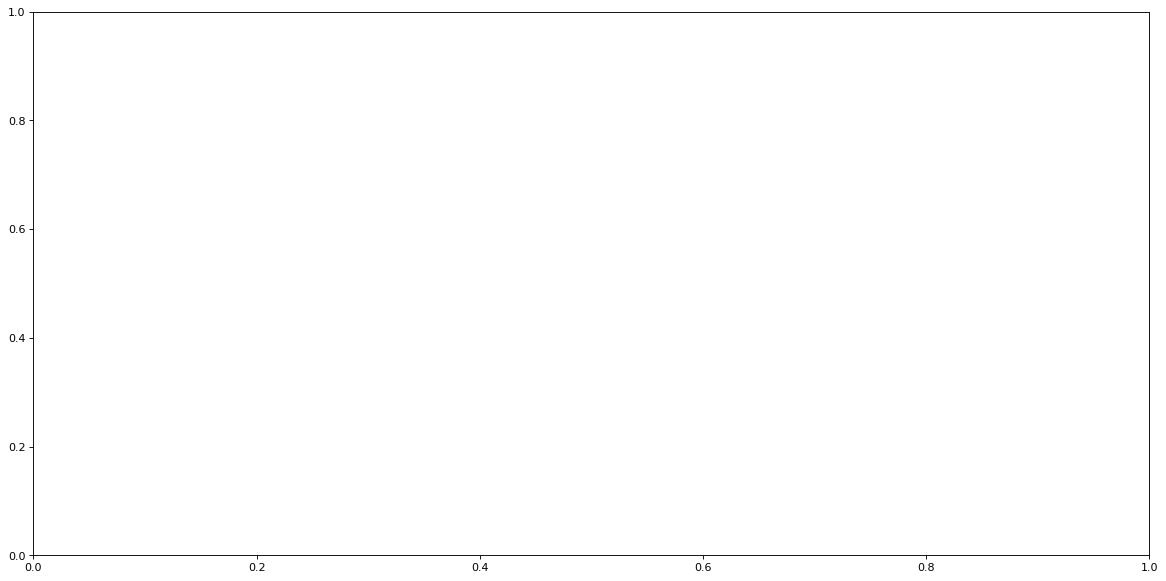

In [68]:
def get_direct_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,mu_cp,ik_vp,mu_vp,wavefunc,\
                           vq,eps,iq_limits,mu_limits,ik_limits):
    ikc_diff = ik_c-ik_cp
    while(ikc_diff < ik_limits[0]):
        ikc_diff += len(ik_limits)
    while(ikc_diff > ik_limits[-1]):
        ikc_diff -= len(ik_limits)

    dir_interaction = 0

    for i in range(2):
        for j in range(2):                    
            dir_interaction += np.conj(wavefunc[1,ik_c,mu_c,i])*wavefunc[0,ik_v,mu_v,j]* \
                               wavefunc[1,ik_cp,mu_cp,i]*np.conj(wavefunc[0,ik_vp,mu_vp,j])* \
                               vq[i,j,ikc_diff-iq_limits[0],mu_c-mu_cp-mu_limits[0]]/ \
                               eps[ikc_diff-iq_limits[0],mu_c-mu_cp-mu_limits[0]]
        
    
    return dir_interaction

def get_xchange_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,mu_cp,ik_vp,mu_vp,ik_cm,wavefunc,\
                           vq,iq_limits,mu_limits):
    xch_interaction = 0
    for i in range(2):
        for j in range(2):
            xch_interaction += np.conj(wavefunc[1,ik_c,mu_c,i])*wavefunc[0,ik_v,mu_v,i]* \
                               wavefunc[1,ik_cp,mu_cp,j]*np.conj(wavefunc[0,ik_vp,mu_vp,j])* \
                               vq[i,j,ik_cm-iq_limits[0],mu_c-mu_v-mu_limits[0]]
    return xch_interaction


            

def get_A_exciton_energy(ikc_range, energy, wavefunc, spin='singlet', mode='extend'):
    assert spin in ['singlet', 'triplet'], "spin should be either singlet or triplet"
    ik_cm_limits = range(-(ikc_range.shape[1]-1), (ikc_range.shape[1]-1)+1)
    nk_cm = len(ik_cm_limits)
    nk_c = ikc_range.shape[1]
    ex_energy_A1 = np.zeros((nk_cm,nk_c))
    ex_energy_A2 = np.zeros((nk_cm,nk_c))
    k_cm_vec = np.zeros((nk_cm,1))
    
    ikc_limits = ikc_range[0,:,0]
    ik_limits = range(0,energy.shape[1])
    

    mu_valley_1, mu_valley_2 = ikc_range[0,0,1], ikc_range[1,0,1]
    mu_limits = range(-abs(mu_valley_1-mu_valley_2),abs(mu_valley_1-mu_valley_2)+1)

    iq_limits_11 = ik_cm_limits
    vq_11,_ = calculate_vq(iq_limits_11, mu_limits, number_of_unit_cells+1)
    PI_11,_ = calculate_PI(iq_limits_11, mu_limits, el_energy_K2ext, el_wavefunc_K2ext)
    eps_11 = 2*(1+ np.multiply(PI_11,np.real(np.mean(vq_11,axis=(0,1)))))

#     iq_12_max = np.amax(ikc_range[0,:,0])-np.amin(ikc_range[1,:,0])
#     iq_12_min = np.amin(ikc_range[0,:,0])-np.amin(ikc_range[1,:,0])
    iq_12_max = 16304
    iq_12_min = 15338
    iq_limits_12 = range(iq_12_min,iq_12_max+1)

    vq_12,_ = calculate_vq(iq_limits_12, mu_limits, number_of_unit_cells+1)
    PI_12,_ = calculate_PI(iq_limits_12, mu_limits, el_energy_K2ext, el_wavefunc_K2ext)
    eps_12 = 2*(1+ np.multiply(PI_12,np.real(np.mean(vq_12,axis=(0,1)))))

    E_transition_11 = np.zeros((nk_c))
    E_transition_22 = np.zeros((nk_c))
    
    Kernel_11 = np.zeros((nk_c,nk_c),dtype='complex64')
    Kernel_12 = np.zeros((nk_c,nk_c),dtype='complex64')
    Kernel = np.zeros((nk_c,nk_c),dtype='complex64')
    
    for ik_cm_idx, ik_cm in enumerate(tqdm(ik_cm_limits)):
        k_cm_vec[ik_cm_idx] = ik_cm*np.linalg.norm(dk_l)
        
        Kernel_11.fill(0)
        Kernel_12.fill(0)
        
        # transition energies, diagonal terms
        for ik_c_idx in range(nk_c):
            ik_c = ikc_range[0,ik_c_idx,0]
            mu_c = ikc_range[0,ik_c_idx,1]
            ik_v = get_ikv(ik_c, ik_cm, ikc_limits, ik_limits, mode)
            mu_v = mu_c
            
            Kernel_11[ik_c_idx,ik_c_idx] = energy[1,ik_c,mu_c] - energy[0,ik_v,mu_v]
        
        # valley_1 to valley_1 interaction
        for ik_c_idx in range(nk_c):
            ik_c = ikc_range[0,ik_c_idx,0]
            mu_c = ikc_range[0,ik_c_idx,1]
            ik_v = get_ikv(ik_c, ik_cm, ikc_limits, ik_limits, mode)
            mu_v = mu_c
            
            for ik_cp_idx in range(ik_c_idx+1):
                ik_cp = ikc_range[0,ik_cp_idx,0]
                mu_cp = ikc_range[0,ik_cp_idx,1]
                ik_vp = get_ikv(ik_cp, ik_cm, ikc_limits, ik_limits, mode)
                mu_vp = mu_cp

                assert(mu_c-mu_cp in mu_limits)
                
                Kernel_11[ik_c_idx,ik_cp_idx] -= get_direct_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,\
                                                                     mu_cp,ik_vp,mu_vp,wavefunc,\
                                                                     vq_11,eps_11,iq_limits_11,mu_limits,ik_limits)
                if spin is 'singlet':
                    Kernel_11[ik_c_idx,ik_cp_idx] += 2*get_xchange_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,\
                                                                     mu_cp,ik_vp,mu_vp,ik_cm, wavefunc,\
                                                                     vq_11,iq_limits_11,mu_limits)
                    
        # valley_1 to valley_2 interaction
        for ik_c_idx in range(nk_c):
            ik_c = ikc_range[0,ik_c_idx,0]
            mu_c = ikc_range[0,ik_c_idx,1]
            ik_v = get_ikv(ik_c, ik_cm, ikc_limits, ik_limits, mode)
            mu_v = mu_c
            
            for ik_vp_idx in range(ik_c_idx,nk_c):
                ik_vp = ikc_range[1,ik_vp_idx,0]
                mu_vp = ikc_range[1,ik_vp_idx,1]
                ik_cp = get_ikc(ik_vp, ik_cm, ikc_limits, ik_limits, mode)
                mu_cp = mu_vp

                assert(mu_c-mu_vp in mu_limits)
                
                Kernel_12[ik_c_idx,nk_c-1-ik_vp_idx] -= get_direct_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,\
                                                                     mu_cp,ik_vp,mu_vp,wavefunc,\
                                                                     vq_12,eps_12,iq_limits_12,mu_limits,ik_limits)
                
                if spin is 'singlet':
                    Kernel_12[ik_c_idx,nk_c-1-ik_vp_idx] += 2*get_xchange_interaction(ik_c,mu_c,ik_v,mu_v,ik_cp,\
                                                                     mu_cp,ik_vp,mu_vp,ik_cm, wavefunc,\
                                                                     vq_11,iq_limits_11,mu_limits)

        Kernel = Kernel_11-Kernel_12
        E_quasi = np.linalg.eigvalsh(Kernel,UPLO='L')

        E_quasi = np.sort(E_quasi,kind='heapsort')
        ex_energy_A1[ik_cm_idx,:] = E_quasi
        
        Kernel = Kernel_11+Kernel_12
        E_quasi = np.linalg.eigvalsh(Kernel,UPLO='L')

        E_quasi = np.sort(E_quasi,kind='heapsort')
        ex_energy_A2[ik_cm_idx,:] = E_quasi
        
    return ex_energy_A1, ex_energy_A2, k_cm_vec

# ex_energy_A1, ex_energy_A2, k_cm_vec = get_A_exciton_energy(ikc_range=ikc_range,\
#                 energy=el_energy_K2ext, wavefunc=el_wavefunc_K2ext, spin='triplet', mode='extend')

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(ex_energy_A1.shape[1]):
    plt.plot(k_cm_vec*1e-9, ex_energy_A1[:,dim1]/eV, linestyle='-', linewidth=3, color='blue')
    plt.plot(k_cm_vec*1e-9, ex_energy_A1[::-1,dim1]/eV, linestyle='-', linewidth=3, color='green')
# plt.plot(k_cm_vec*1e-9, quasi_particle_energy[:,0]/eV, linestyle='-', linewidth=5, color='red')
plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
          'Exciton energy versus longitudinal center of mass k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
plt.savefig('Quasiparticle_transition_energy_using_K2extended_rep.png')
# plt.xlim([-1,1])
# plt.ylim([0.6,1.2])

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(ex_energy_A2.shape[1]):
    plt.plot(k_cm_vec*1e-9, ex_energy_A2[:,dim1]/eV, linestyle='-', linewidth=3, color='blue')
# plt.plot(k_cm_vec*1e-9, quasi_particle_energy[:,0]/eV, linestyle='-', linewidth=5, color='red')
plt.title('CNT chirality ({},{}) \n'.format(n,m)+\
          'Exciton energy versus longitudinal center of mass k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/nm]', size=20)
plt.ylabel('Energy [eV]', size=20)
plt.savefig('Quasiparticle_transition_energy_using_K2extended_rep.png')
plt.xlim([-1,1])
plt.ylim([0.6,1.2])

In [48]:
print(15982-15338)
print()

644